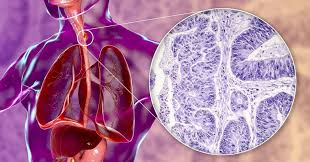

Esophageal cancer is cancer that occurs in the esophagus — a long, hollow tube that runs from your throat to your stomach. Your esophagus helps move the food you swallow from the back of your throat to your stomach to be digested.

Esophageal cancer usually begins in the cells that line the inside of the esophagus. Esophageal cancer can occur anywhere along the esophagus. More men than women get esophageal cancer.

Esophageal cancer is the sixth most common cause of cancer deaths worldwide. Incidence rates vary within different geographic locations. In some regions, higher rates of esophageal cancer may be attributed to tobacco and alcohol use or particular nutritional habits and obesity.

# Importing libraries

In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os                       
import numpy as np 
import h5py
import pandas as pd             
import seaborn as sns
import torch                    
import matplotlib.pyplot as plt 
import torch.nn as nn          
from torch.utils.data import DataLoader  
from PIL import Image          
import torch.nn.functional as F 
import torchvision.transforms as transforms   
from torchvision.utils import make_grid       
from torchvision.datasets import ImageFolder  
from torchsummary import summary              
import tensorflow as ts 
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

2024-02-28 16:24:00.828343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 16:24:00.828665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 16:24:01.022469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data loading and exploring

In [3]:
esophageal_dir = "/kaggle/input/esophagealcancer/Endoscopy-esophagus"
esophageals = os.listdir(esophageal_dir)

In [4]:
esophageals 

['no-esophagus', 'esophagus']

In [5]:
# Number of images for each disease
nums_train = {}

for esophageal in esophageals:
    nums_train[esophageal] = len(os.listdir(os.path.join(esophageal_dir, esophageal)))

img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution:')
print(img_per_class_train)

Train data distribution:
              no. of images
no-esophagus           8973
esophagus              1689


# Show some example for Esophageal cancer

In [6]:
# Function to show image
train = ImageFolder(esophageal_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

Label :esophagus(0)
Label :esophagus(0)
Label :no-esophagus(1)
Label :no-esophagus(1)
Label :no-esophagus(1)
Label :no-esophagus(1)


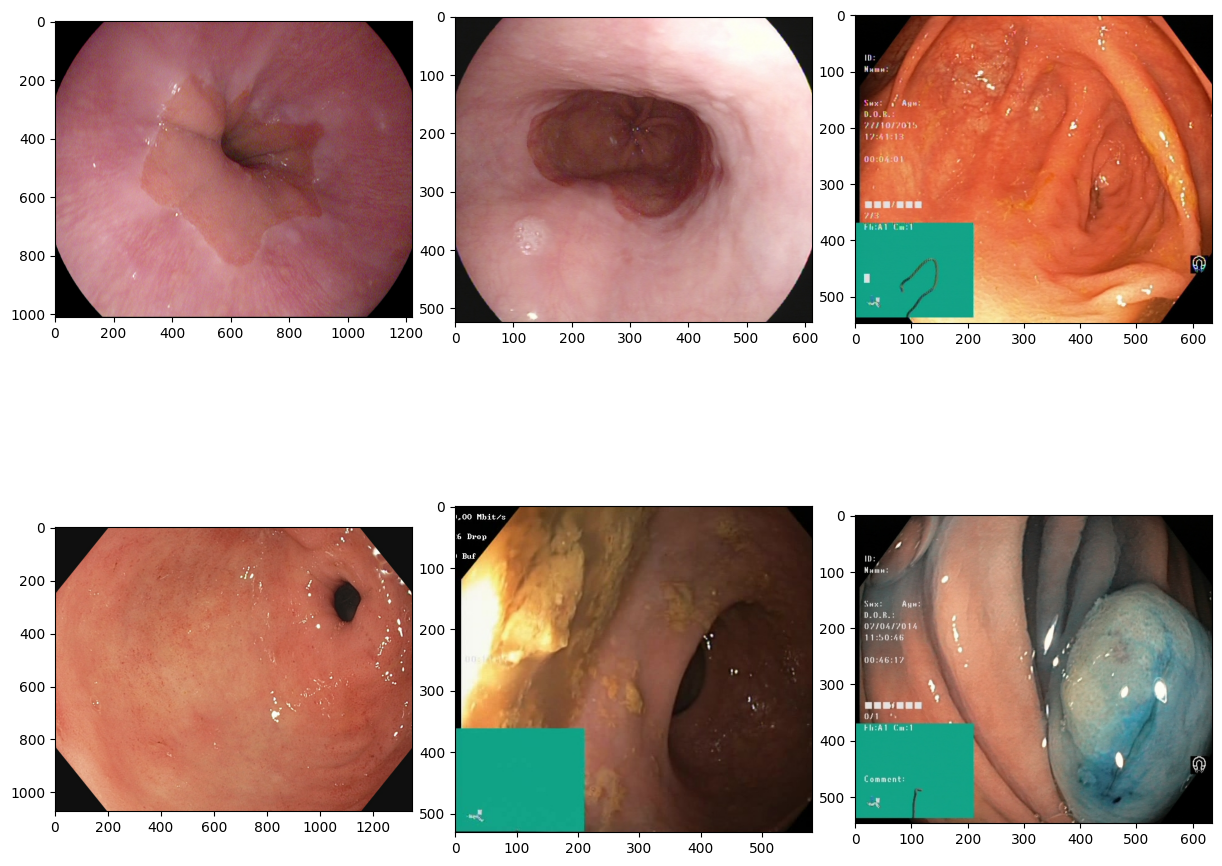

In [7]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[1]))
axs[0,1].imshow(show_image(*train[1100]))
axs[1, 0].imshow(show_image(*train[2010]))
axs[1,1].imshow(show_image(*train[3500]))
axs[0,2].imshow(show_image(*train[4120]))
axs[1,2].imshow(show_image(*train[4860]))

Label :no-esophagus(1)
Label :no-esophagus(1)
Label :no-esophagus(1)
Label :no-esophagus(1)
Label :no-esophagus(1)
Label :no-esophagus(1)


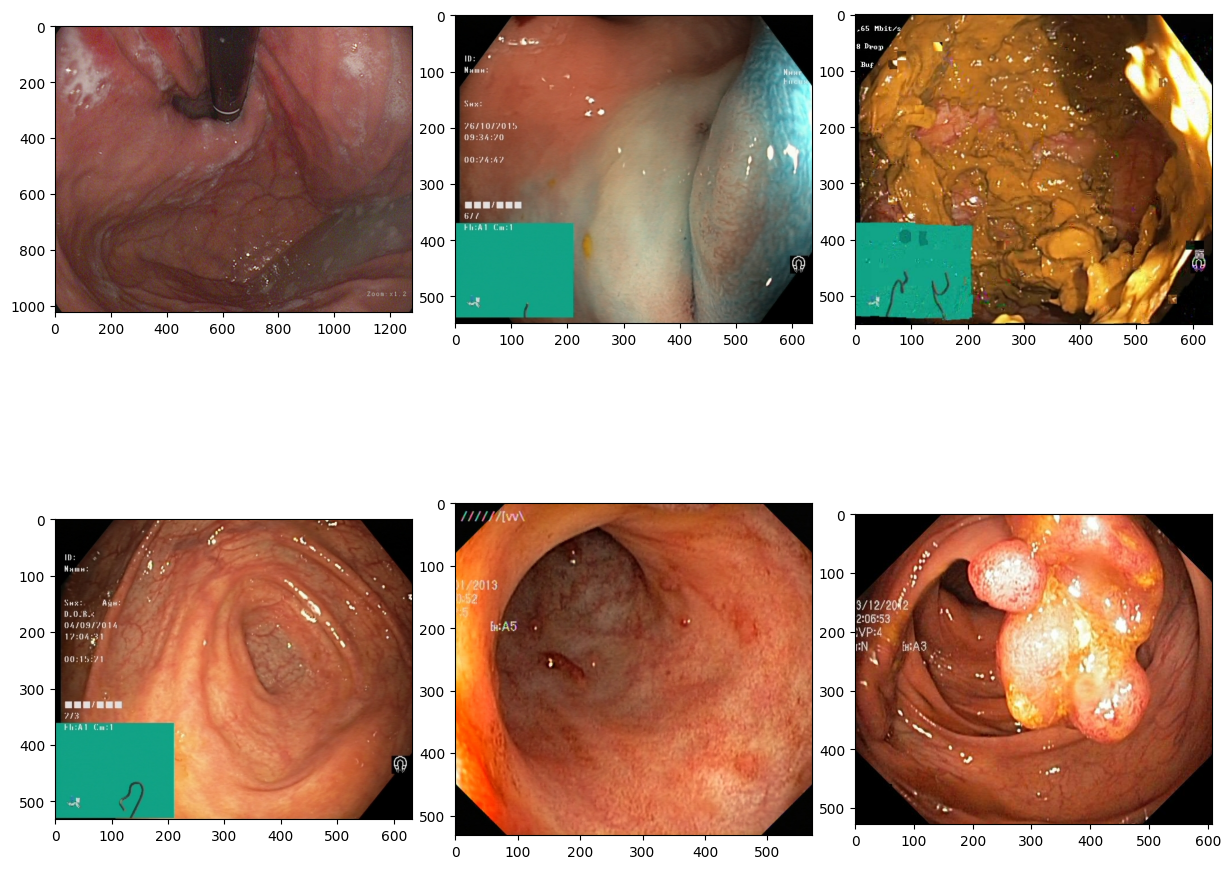

In [8]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[5010]))
axs[0,1].imshow(show_image(*train[6050]))
axs[1, 0].imshow(show_image(*train[7000]))
axs[1,1].imshow(show_image(*train[7500]))
axs[0,2].imshow(show_image(*train[8000]))
axs[1,2].imshow(show_image(*train[8620]))

# Modeling

In [9]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 20 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.2
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory(esophageal_dir, subset='training', target_size=(224,224), batch_size=64, color_mode='rgb', 
                                            class_mode='categorical', shuffle=True)

val_data = valid_gen.flow_from_directory(esophageal_dir, subset='validation', target_size=(224,224), batch_size=64, color_mode='rgb', 
                                            class_mode='categorical', shuffle=False)

Found 8531 images belonging to 2 classes.
Found 2131 images belonging to 2 classes.


In [10]:
test_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_data = test_gen.flow_from_directory(
    esophageal_dir, 
    target_size=(224,224), 
    batch_size=64, 
    color_mode='rgb', 
    class_mode='categorical', 
    shuffle=False
)

Found 10662 images belonging to 2 classes.


In [11]:
class_names = {0: 'esophagus', 1: 'no-esophagus'}

In [12]:
import numpy
unique, counts = numpy.unique(val_data.classes, return_counts=True)

dict(zip(unique, counts))

{0: 337, 1: 1794}

In [13]:
print(class_names)

{0: 'esophagus', 1: 'no-esophagus'}


In [14]:
# Define the model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(64, 3, activation='relu'))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(128, 3, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,186 (84.86 MB)

 Trainable params: 22,245,186 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
history = model.fit(train_data,
                      validation_data=val_data,
                      epochs=10)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 897s 7s/step - accuracy: 0.8826 - loss: 0.6544 - val_accuracy: 0.9812 - val_loss: 0.0705
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 878s 6s/step - accuracy: 0.9778 - loss: 0.0525 - val_accuracy: 0.9892 - val_loss: 0.0384
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 947s 7s/step - accuracy: 0.9814 - loss: 0.0473 - val_accuracy: 0.9897 - val_loss: 0.0399
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 867s 6s/step - accuracy: 0.9799 - loss: 0.0509 - val_accuracy: 0.9864 - val_loss: 0.0558
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 842s 6s/step - accuracy: 0.9905 - loss: 0.0320 - val_accuracy: 0.9925 - val_loss: 0.0256
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 834s 6s/step - accuracy: 0.9913 - loss: 0.0277 - val_accuracy: 0.9822 - val_loss: 0.0593
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 865s 6s/step - accuracy: 0.9870 - loss: 0.0387 - val_accuracy: 0.9883 - val_loss: 0.0364
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 867s 6s/step - accuracy: 0.9872 - loss: 0.0357 - val_accuracy: 0.983

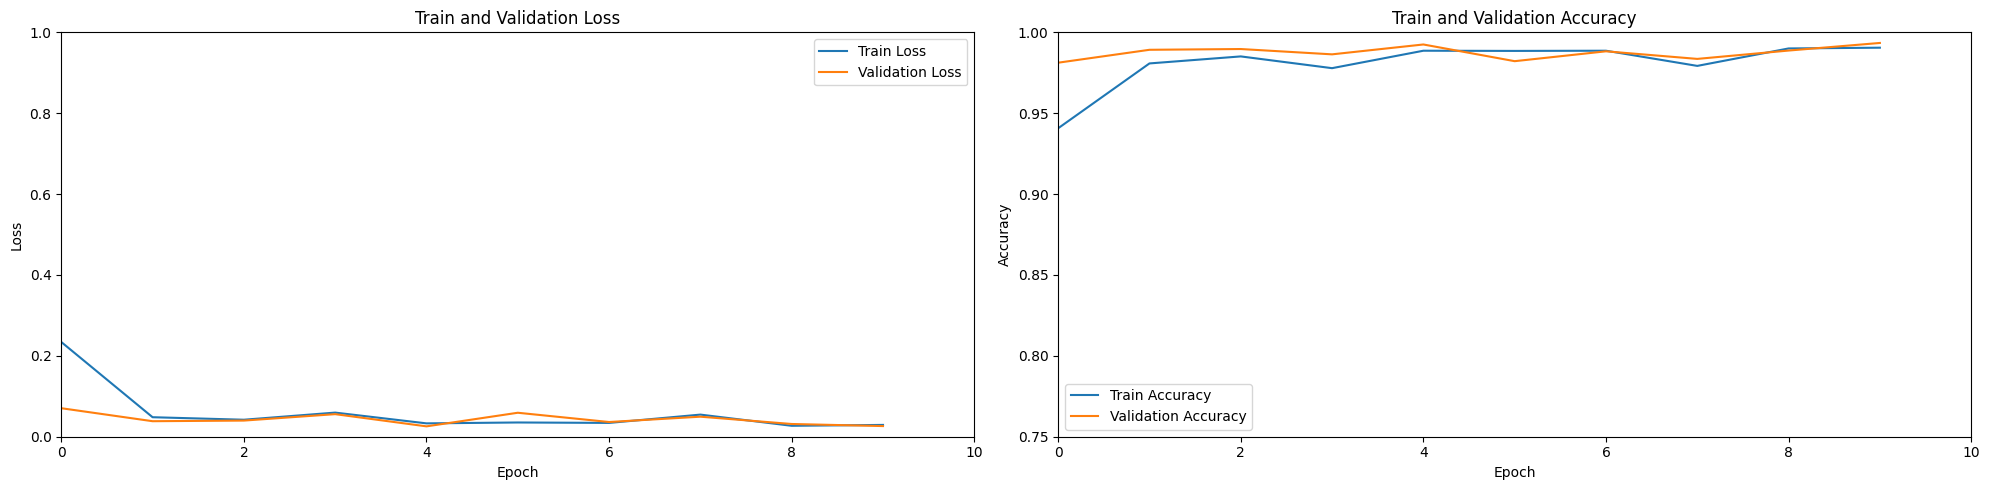

In [16]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)  # Adjusted to 10 epochs
plt.ylim(0.0, 1.0)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 10)  # Adjusted to 10 epochs
plt.ylim(0.75, 1.0)
plt.legend()
plt.tight_layout()

In [17]:
from sklearn.metrics import classification_report

Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

34/34 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       337
           1       0.99      1.00      1.00      1794

    accuracy                           0.99      2131
   macro avg       0.99      0.98      0.99      2131
weighted avg       0.99      0.99      0.99      2131



# Evaluation

In [18]:
loss, accuracy = model.evaluate(train_data)

134/134 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.9965 - loss: 0.0188


In [19]:
accuracy*100

99.58972930908203

In [20]:
val_loss, val_accuracy = model.evaluate(val_data)  
val_accuracy * 100

34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9829 - loss: 0.0647


99.34303164482117

In [21]:
test_loss, test_accuracy = model.evaluate(val_data)
test_accuracy_percentage = test_accuracy * 100
print("Test Accuracy: {:.2f}%".format(test_accuracy_percentage))

34/34 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9829 - loss: 0.0647
Test Accuracy: 99.34%


# Prediction

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

First image to predict
Actual label: 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Predicted label: 0


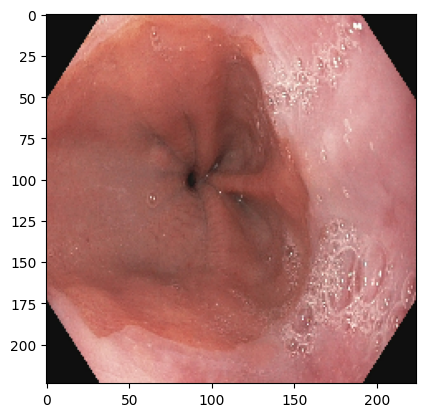

In [23]:
import numpy as np

# Assuming class_names is defined elsewhere in your code
class_names = list(class_names)

for images_batch, labels_batch in test_data:
    first_image = images_batch[0]
    
    # Convert labels_batch[0] to integer
    first_label = np.argmax(labels_batch[0])
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    # Predict the label for the batch
    batch_prediction = model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0])
    print("Predicted label:", class_names[predicted_label])
    
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


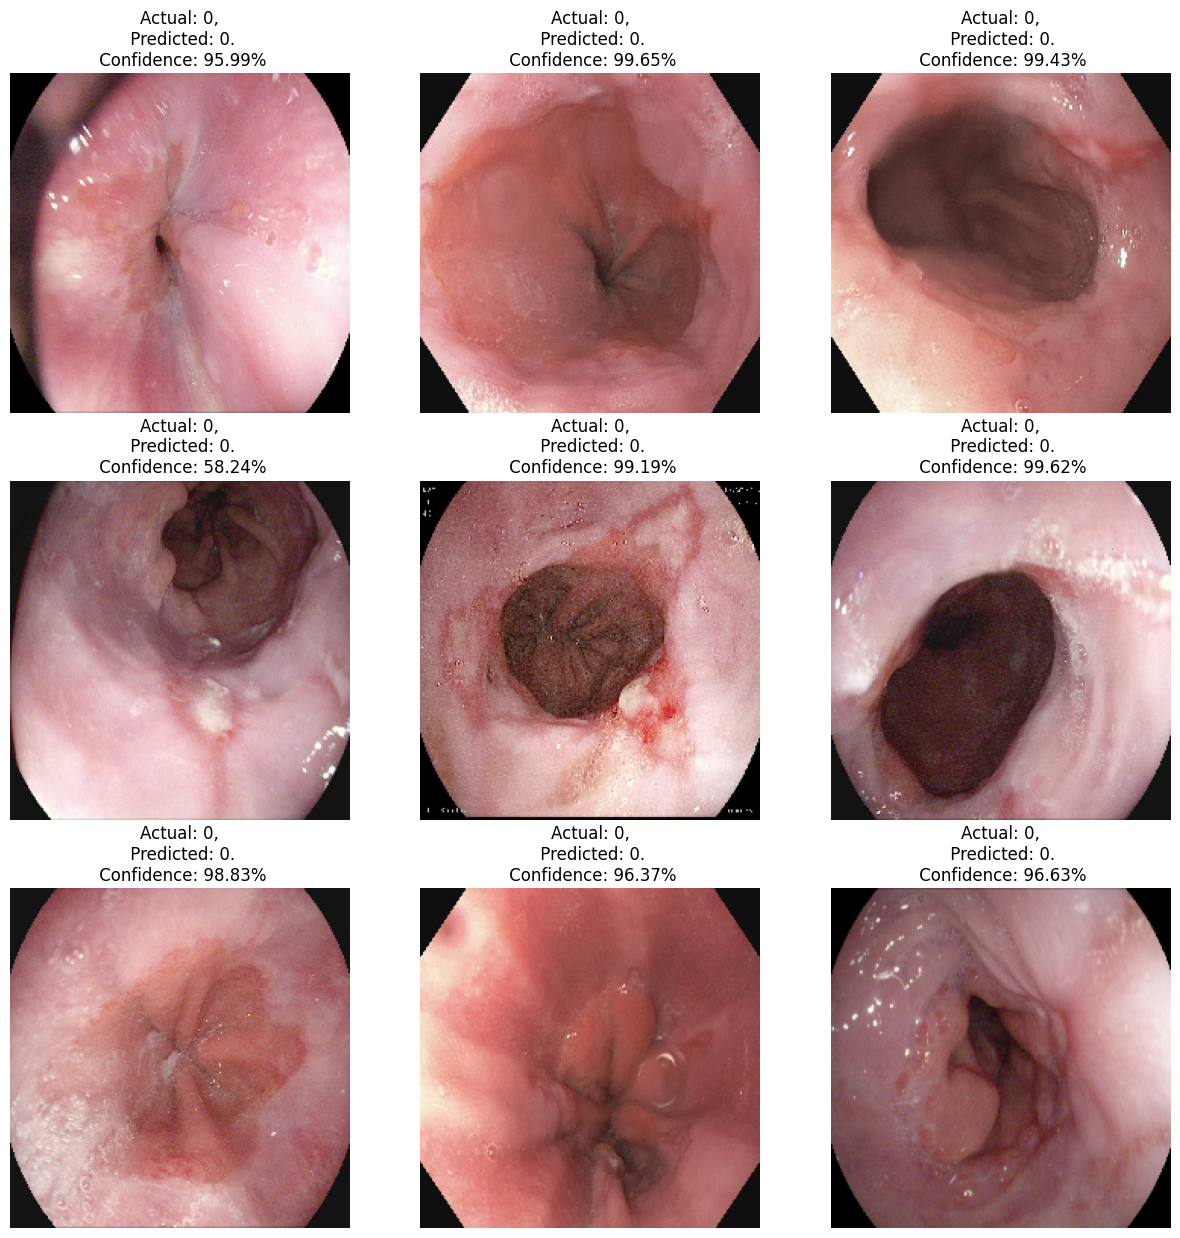

In [24]:
import tensorflow as tf

plt.figure(figsize=(15, 15))
for images, labels in test_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        
        # Convert labels[i] to integer using np.argmax()
        actual_class = class_names[np.argmax(labels[i])]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break


# Convert model to h5

In [25]:
model.save('Esophageal cancer.h5')

In [26]:
import tensorflow as tf

new_model = tf.keras.models.load_model('Esophageal cancer.h5')
results = new_model.evaluate(val_data)
tf.print('Accuracy: ', results[1]*100)

34/34 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9829 - loss: 0.0647
Accuracy:  99.34303164482117


In [27]:
from PIL import Image
import numpy as np
# Load the test image
test_image_path = "/kaggle/input/esophagealcancer/Endoscopy-esophagus/esophagus/001f937f-2a43-4df1-a6be-9673410a1924.jpg"
test_image = Image.open(test_image_path)
# Preprocess the image (resize, normalize, etc.)
# Example:
test_image = test_image.resize((224, 224))  # Resize the image to match the input size
test_image = np.array(test_image) / 255.0   # Normalize pixel values
# Add a batch dimension to the image
test_image = np.expand_dims(test_image, axis=0)
# Make prediction
prediction = new_model.predict(test_image)
# Get the predicted class label
predicted_class = np.argmax(prediction)
# Print the predicted class
print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted Class: 0


# Confusion Matrix 

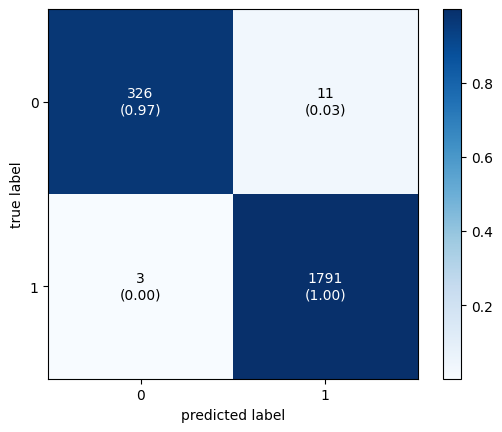

In [28]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(val_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()